In [32]:
import torch
import pickle
from pathlib import Path
from tqdm import tqdm
import re

def convert_hec_ras_pickles(input_dir, output_dir, num_static=9, num_dynamic=4):
    input_dir, output_dir = Path(input_dir), Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    pkl_files = list(input_dir.glob("*.pkl"))
    print(f"🔄 Found {len(pkl_files)} files. Starting conversion...")

    for pkl_path in tqdm(pkl_files):
        try:
            with open(pkl_path, 'rb') as f:
                raw_data = pickle.load(f)
            
            # --- THE UNWRAP FIX ---
            sim_id = pkl_path.stem
            if isinstance(raw_data, dict):
                # Try the stem as key, or just take the first value if it's the only one
                sim_list = raw_data.get(sim_id, list(raw_data.values())[0])
            else:
                sim_list = raw_data

            if not isinstance(sim_list, list) or len(sim_list) < 2:
                continue

            processed_sim = []
            T = len(sim_list)
            
            # Extract mesh ID for the new modular class
            match = re.search(r'\d+', sim_id)
            sim_id_int = int(match.group()) if match else abs(hash(sim_id)) % 100000

            for t in range(T - 1):
                data_t = sim_list[t].clone()
                data_next = sim_list[t+1]
                
                # 1. Partition Features (GPARC mapping: 0-8 static, 9-12 dynamic)
                static = data_t.x[:, :num_static]
                dynamic = data_t.x[:, num_static : num_static + num_dynamic]
                data_t.x = torch.cat([static, dynamic], dim=1)
                
                # 2. Shift Target (y[t] = ground_truth[t+1])
                data_t.y = data_next.y.clone()
                
                # 3. Inject mesh_id attribute
                data_t.mesh_id = torch.tensor([sim_id_int], dtype=torch.long)
                
                processed_sim.append(data_t)
            
            # Save the flat list of Data objects
            torch.save(processed_sim, output_dir / f"{sim_id}.pt")
            
        except Exception as e:
            print(f"❌ Failed {pkl_path.name}: {e}")

# EXECUTION:
input_folder = "/standard/sds_baek_energetic/HEC_RAS (River)/train_normalized"
output_folder = "/standard/sds_baek_energetic/HEC_RAS (River)/pt_train_normalized"
convert_hec_ras_pickles(input_folder, output_folder)

🔄 Found 700 files. Starting conversion...


100%|██████████| 700/700 [05:23<00:00,  2.16it/s]


In [6]:
def load_hec_ras_mesh_v2(hdf_path: Path, sim_id: str):
    """Specific loader using verified HEC-RAS internal paths."""
    with h5py.File(hdf_path, "r") as f:
        # Determine paths based on simulation type
        if "iw" in sim_id:
            # Iowa River / Flood GNN Mesh
            facepts_path = "Geometry/2D Flow Areas/Flow Area/FacePoints Coordinate"
            cells_path    = "Geometry/2D Flow Areas/Flow Area/Cells FacePoint Indexes"
        else:
            # White River / Muncie Mesh
            facepts_path = "Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate"
            cells_path    = "Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes"
            
        try:
            facepts = f[facepts_path][:]
            cells   = f[cells_path][:]
            print(f"✅ Mesh Loaded from {hdf_path.name}")
        except KeyError as e:
            print(f"❌ Path Error: Could not find {e} in {hdf_path.name}")
            # Diagnostic: Print what IS available
            print("Available groups in 'Geometry/2D Flow Areas':", list(f["Geometry/2D Flow Areas"].keys()))
            raise
            
    return facepts, cells

--- Inspecting H348iw ---
✅ Successfully unwrapped dictionary. Found 22 timesteps.
✅ Mesh Loaded from Flood_GNN.p01.hdf


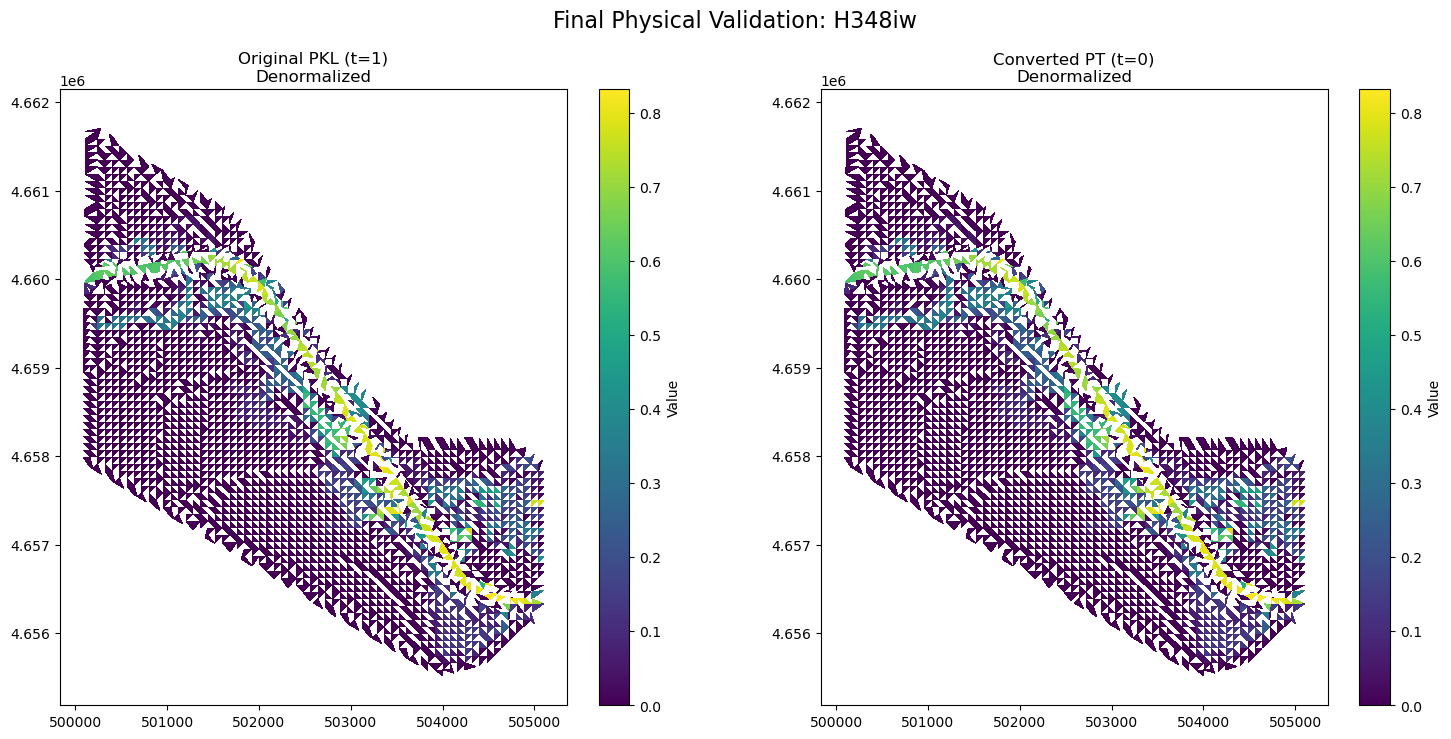

Max Physical Difference: 0.00e+00


In [19]:
import torch
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from pathlib import Path

def run_physical_validation():
    # --- 1. CONFIG & PATHS ---
    base_path = Path("/standard/sds_baek_energetic/HEC_RAS (River)")
    extrema_path = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
    
    sim_id = "H348iw"
    pkl_path = base_path / "test_normalized" / f"{sim_id}.pkl"
    pt_path  = base_path / "pt_val_normalized" / f"{sim_id}.pt"
    hdf_path = base_path / ("Flood_GNN.p01.hdf" if "iw" in sim_id else "Muncie2D_SI.p02.hdf")

    FEAT_IDX = 0 

    # --- 2. LOAD DATA ---
    print(f"--- Inspecting {sim_id} ---")
    
    with open(pkl_path, 'rb') as f:
        raw_data = pickle.load(f)
    
    # UNWRAP DICTIONARY: 
    # Since your diagnostic shows {'H348iw': [list_of_data]}, we extract the list.
    if isinstance(raw_data, dict) and sim_id in raw_data:
        orig_sim = raw_data[sim_id]
        print(f"✅ Successfully unwrapped dictionary. Found {len(orig_sim)} timesteps.")
    else:
        orig_sim = raw_data
        print(f"ℹ️ Data was not nested or key mismatch. Proceeding with raw load.")

    conv_sim = torch.load(pt_path, weights_only=False)

    # --- 3. EXTRACT & DENORMALIZE ---
    # Load extrema
    extrema = torch.load(extrema_path)
    y_min = extrema['y_min'][FEAT_IDX].item()
    y_max = extrema['y_max'][FEAT_IDX].item()

    # Get y from Original Step 1 and Converted Step 0
    raw_orig_col = orig_sim[1].y[:, FEAT_IDX].numpy()
    raw_conv_col = conv_sim[0].y[:, FEAT_IDX].numpy()

    phys_orig = raw_orig_col * (y_max - y_min) + y_min
    phys_conv = raw_conv_col * (y_max - y_min) + y_min

    # --- 4. MESH LOADING & PLOTTING ---
    facepts, cells = load_hec_ras_mesh_v2(hdf_path, sim_id)
    
    # Clean padding from HEC-RAS cells
    triangles = cells[:, :3]
    valid_mask = np.all(triangles >= 0, axis=1)
    triang = tri.Triangulation(facepts[:, 0], facepts[:, 1], triangles[valid_mask])

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    vmin, vmax = phys_orig.min(), phys_orig.max()

    im1 = axes[0].tripcolor(triang, phys_orig, shading='flat', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(im1, ax=axes[0], label="Value")
    axes[0].set_title(f"Original PKL (t=1)\nDenormalized")

    im2 = axes[1].tripcolor(triang, phys_conv, shading='flat', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(im2, ax=axes[1], label="Value")
    axes[1].set_title(f"Converted PT (t=0)\nDenormalized")

    plt.suptitle(f"Final Physical Validation: {sim_id}", fontsize=16)
    plt.show()

    diff = np.abs(phys_orig - phys_conv).max()
    print(f"Max Physical Difference: {diff:.2e}")

if __name__ == "__main__":
    run_physical_validation()

In [20]:
test_path = Path("/standard/sds_baek_energetic/HEC_RAS (River)/pt_val_normalized/H348iw.pt")
data = torch.load(test_path, weights_only=False)

print(f"Success! Converted file length: {len(data)}")
print(f"Sample data.x shape: {data[0].x.shape}") # Should be [Nodes, 13]
print(f"Sample data.y shape: {data[0].y.shape}") # Should be [Nodes, 4]

Success! Converted file length: 21
Sample data.x shape: torch.Size([2467, 13])
Sample data.y shape: torch.Size([2467, 4])


✅ Mesh Loaded from Flood_GNN.p01.hdf
🎨 Building polygons for clean rendering...


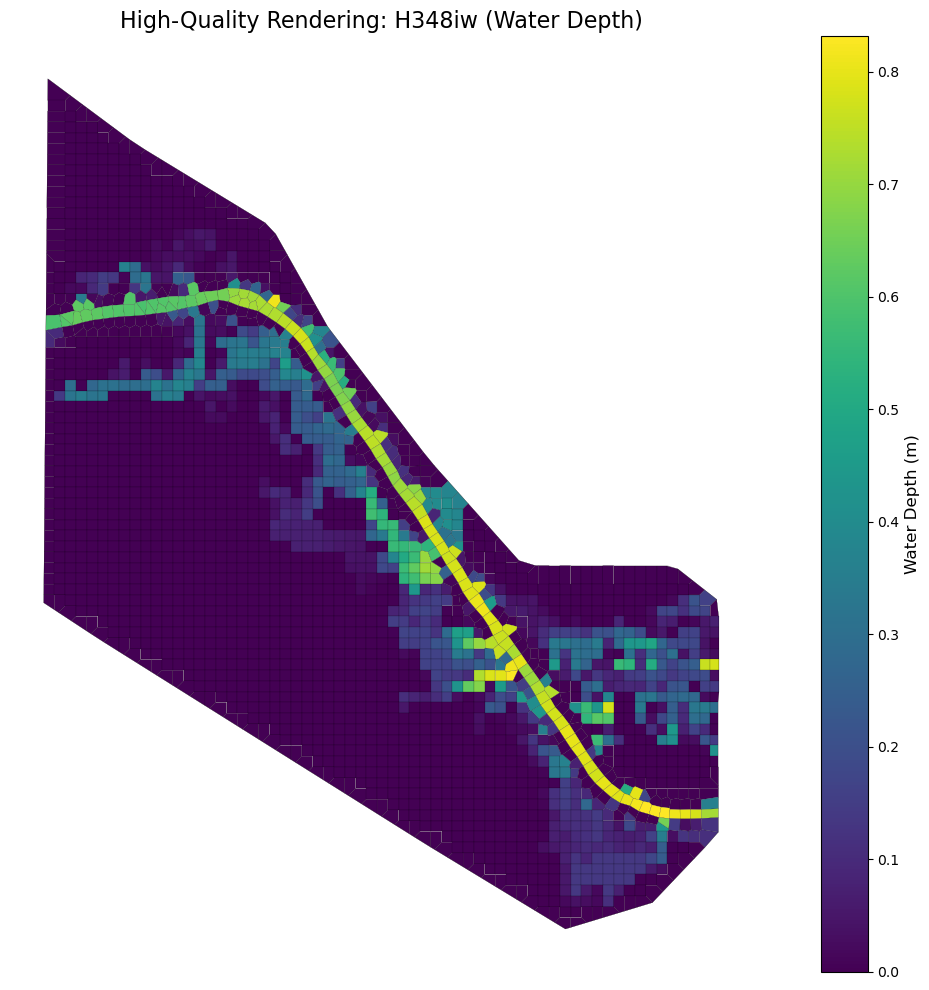

In [21]:
import torch
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from pathlib import Path

def get_clean_polygons(facepts, cells):
    """
    Converts HEC-RAS facepts and padded cell indices into 
    a list of coordinate arrays for PolyCollection.
    """
    polys = []
    for cell_ids in cells:
        # Filter out the -1 padding used by HEC-RAS
        valid_ids = cell_ids[cell_ids >= 0].astype(int)
        # Grab the (x, y) coordinates for this cell's vertices
        pts = facepts[valid_ids]
        polys.append(pts)
    return polys

def run_nice_visualization():
    # --- 1. CONFIG & PATHS ---
    base_path = Path("/standard/sds_baek_energetic/HEC_RAS (River)")
    extrema_path = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
    
    sim_id = "H348iw"
    pt_path = base_path / "pt_val_normalized" / f"{sim_id}.pt"
    hdf_path = base_path / ("Flood_GNN.p01.hdf" if "iw" in sim_id else "Muncie2D_SI.p02.hdf")

    # 0 = Water Depth
    FEAT_IDX = 0 

    # --- 2. LOAD DATA ---
    # Load Extrema for Physical Units
    extrema = torch.load(extrema_path)
    y_min = extrema['y_min'][FEAT_IDX].item()
    y_max = extrema['y_max'][FEAT_IDX].item()

    # Load Converted Data
    conv_sim = torch.load(pt_path, weights_only=False)
    # Get y from Converted Step 0 and denormalize
    raw_vals = conv_sim[0].y[:, FEAT_IDX].numpy()
    phys_vals = raw_vals * (y_max - y_min) + y_min

    # Load Mesh using your verified paths
    facepts, cells = load_hec_ras_mesh_v2(hdf_path, sim_id)
    
    # --- 3. BUILD POLYGONS ---
    print("🎨 Building polygons for clean rendering...")
    polys = get_clean_polygons(facepts, cells)

    # --- 4. PLOTTING ---
    fig, ax = plt.subplots(figsize=(14, 10))

    # Create the PolyCollection
    # We color the faces based on our physical depth values
    pc = PolyCollection(polys, cmap='viridis', edgecolors='black', linewidths=0.1)
    pc.set_array(phys_vals)
    
    ax.add_collection(pc)
    
    # Auto-scale the view to fit the mesh
    ax.autoscale_view()
    
    # Add a nice colorbar
    cbar = fig.colorbar(pc, ax=ax)
    cbar.set_label("Water Depth (m)", fontsize=12)

    ax.set_aspect('equal')
    ax.axis('off') # Cleaner look for river maps
    
    plt.title(f"High-Quality Rendering: {sim_id} (Water Depth)", fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_nice_visualization()

In [24]:
import torch
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path

def create_comparison_gif(sim_id="H348iw", output_name="hecras_comparison.gif"):
    # --- 1. PATHS ---
    base_path = Path("/standard/sds_baek_energetic/HEC_RAS (River)")
    extrema_path = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
    pkl_path = base_path / "val_normalized" / f"{sim_id}.pkl"
    pt_path = base_path / "pt_val_normalized" / f"{sim_id}.pt"
    hdf_path = base_path / ("Flood_GNN.p01.hdf" if "iw" in sim_id else "Muncie2D_SI.p02.hdf")
    
    FEAT_IDX = 0 # Water Depth

    # --- 2. LOAD DATA ---
    extrema = torch.load(extrema_path)
    y_min, y_max = extrema['y_min'][FEAT_IDX].item(), extrema['y_max'][FEAT_IDX].item()

    # Load Original (Nested Dict)
    with open(pkl_path, 'rb') as f:
        raw_pkl = pickle.load(f)
    orig_sim = raw_pkl[sim_id] if isinstance(raw_pkl, dict) else raw_pkl

    # Load Converted PT
    conv_sim = torch.load(pt_path, weights_only=False)
    
    # We define the number of frames based on the shorter list (Converted)
    num_frames = len(conv_sim) 
    print(f"🎬 Processing {num_frames} frames for GIF...")

    # Load Mesh
    facepts, cells = load_hec_ras_mesh_v2(hdf_path, sim_id)
    polys = [facepts[c[c >= 0].astype(int)] for c in cells]

    # --- 3. ANIMATION SETUP ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Global limits for color consistency across all timesteps
    all_vals = [data.y[:, FEAT_IDX].numpy() * (y_max - y_min) + y_min for data in conv_sim]
    v_min, v_max = np.min(all_vals), np.max(all_vals)

    # Initialize PolyCollections
    pc_orig = PolyCollection(polys, cmap='Blues', edgecolors='black', linewidths=0.03)
    pc_conv = PolyCollection(polys, cmap='Blues', edgecolors='black', linewidths=0.03)
    
    for pc, ax, title in zip([pc_orig, pc_conv], [ax1, ax2], ["Original PKL (t+1)", "Converted PT (t)"]):
        pc.set_clim(v_min, v_max)
        ax.add_collection(pc)
        ax.autoscale_view()
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(title, fontsize=14, fontweight='bold')

    fig.colorbar(pc_conv, ax=[ax1, ax2], label="Water Depth (m)", fraction=0.02, pad=0.04)
    
    # Text objects for timestep display
    txt_orig = ax1.text(0.05, 0.95, '', transform=ax1.transAxes, fontsize=12, color='red', fontweight='bold')
    txt_conv = ax2.text(0.05, 0.95, '', transform=ax2.transAxes, fontsize=12, color='red', fontweight='bold')

    # --- 4. UPDATE FUNCTION ---
    def update(frame):
        # Original is frame+1 because PT[0] was built from Original[1]
        val_orig = orig_sim[frame+1].y[:, FEAT_IDX].numpy() * (y_max - y_min) + y_min
        val_conv = conv_sim[frame].y[:, FEAT_IDX].numpy() * (y_max - y_min) + y_min
        
        pc_orig.set_array(val_orig)
        pc_conv.set_array(val_conv)
        
        txt_orig.set_text(f"Orig Timestep: {frame+1}")
        txt_conv.set_text(f"Conv Timestep: {frame}")
        
        if frame % 5 == 0:
            print(f"   Rendering Frame {frame}/{num_frames}...")
            
        return pc_orig, pc_conv, txt_orig, txt_conv

    # --- 5. RENDER ---
    anim = FuncAnimation(fig, update, frames=num_frames, blit=True)
    anim.save(output_name, writer=PillowWriter(fps=4)) # Slower FPS to see the text clearly
    plt.close()
    print(f"✅ GIF Complete: {output_name}")

if __name__ == "__main__":
    create_comparison_gif(sim_id="H348iw", output_name="hecras_comparison_v2.gif")

🎬 Processing 21 frames for GIF...
✅ Mesh Loaded from Flood_GNN.p01.hdf
   Rendering Frame 0/21...
   Rendering Frame 0/21...
   Rendering Frame 0/21...
   Rendering Frame 0/21...
   Rendering Frame 5/21...
   Rendering Frame 10/21...
   Rendering Frame 15/21...
   Rendering Frame 20/21...
✅ GIF Complete: hecras_comparison_v2.gif


In [27]:
import torch
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path

def create_full_comparison_gif(sim_id, output_name="full_comparison.gif"):
    # --- 1. DATA LOADING & UNWRAPPING ---
    base_path = Path("/standard/sds_baek_energetic/HEC_RAS (River)")
    pkl_path = base_path / "val_normalized" / f"{sim_id}.pkl"
    pt_path  = base_path / "pt_val_normalized" / f"{sim_id}.pt"
    
    # Load Original
    with open(pkl_path, 'rb') as f:
        raw_pkl = pickle.load(f)
    orig_sim = raw_pkl[sim_id] if isinstance(raw_pkl, dict) else raw_pkl
    
    # Load Converted
    conv_sim = torch.load(pt_path, weights_only=False)

    # --- 2. FRAME COUNT VERIFICATION ---
    num_orig = len(orig_sim)
    num_conv = len(conv_sim)
    
    print(f"📊 Statistics for {sim_id}:")
    print(f"   Original Timesteps: {num_orig}")
    print(f"   Converted Timesteps: {num_conv} (Expected: {num_orig - 1})")

    # --- 3. MESH SETUP ---
    # Determine which mesh based on 'iw' suffix
    is_flood_gnn = "iw" in sim_id
    hdf_path = base_path / ("Flood_GNN.p01.hdf" if is_flood_gnn else "Muncie2D_SI.p02.hdf")
    facepts, cells = load_hec_ras_mesh_v2(hdf_path, sim_id)
    polys = [facepts[c[c >= 0].astype(int)] for c in cells]

    # --- 4. ANIMATION SETUP ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Load extrema for physical units
    extrema = torch.load("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
    y_min, y_max = extrema['y_min'][0].item(), extrema['y_max'][0].item()

    # Pre-calculate min/max for stable colorbar
    all_vals = [d.y[:, 0].numpy() * (y_max - y_min) + y_min for d in conv_sim]
    v_min, v_max = np.min(all_vals), np.max(all_vals)

    pc_orig = PolyCollection(polys, cmap='Blues', edgecolors='black', linewidths=0.03)
    pc_conv = PolyCollection(polys, cmap='Blues', edgecolors='black', linewidths=0.03)
    
    for pc, ax, title in zip([pc_orig, pc_conv], [ax1, ax2], ["Original Ground Truth", "Converted PT Target"]):
        pc.set_clim(v_min, v_max)
        ax.add_collection(pc)
        ax.autoscale_view()
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(title, fontsize=14, fontweight='bold')

    txt_frame = fig.text(0.5, 0.92, '', ha='center', fontsize=14, color='darkred', fontweight='bold')

    # --- 5. UPDATE FUNCTION ---
    def update(t):
        # Index 't' in conv_sim corresponds to index 't+1' in orig_sim
        val_orig = orig_sim[t+1].y[:, 0].numpy() * (y_max - y_min) + y_min
        val_conv = conv_sim[t].y[:, 0].numpy() * (y_max - y_min) + y_min
        
        pc_orig.set_array(val_orig)
        pc_conv.set_array(val_conv)
        
        txt_frame.set_text(f"Displaying Frame {t+1}/{num_conv} | (Orig Index {t+1} vs Conv Index {t})")
        return pc_orig, pc_conv, txt_frame

    # --- 6. SAVE ALL FRAMES ---
    # We use 'num_conv' to ensure every converted frame is shown
    anim = FuncAnimation(fig, update, frames=num_conv, blit=True)
    
    print(f"🎬 Rendering all {num_conv} timesteps...")
    anim.save(output_name, writer=PillowWriter(fps=4))
    plt.close()
    print(f"✅ Full comparison GIF saved as: {output_name}")

if __name__ == "__main__":
    # Test on a White River simulation (Muncie)
    # Make sure to provide a valid ID from your folder
    create_full_comparison_gif(sim_id="H30", output_name="white_river_full_check.gif")

📊 Statistics for H30:
   Original Timesteps: 97
   Converted Timesteps: 96 (Expected: 96)
✅ Mesh Loaded from Muncie2D_SI.p02.hdf
🎬 Rendering all 96 timesteps...
✅ Full comparison GIF saved as: white_river_full_check.gif


In [1]:
import torch
import pickle
from pathlib import Path
import numpy as np
from tqdm import tqdm

def validate_split(split_name, pkl_dir, pt_dir, num_samples=10):
    pkl_dir, pt_dir = Path(pkl_dir), Path(pt_dir)
    pt_files = list(pt_dir.glob("*.pt"))
    
    # Randomly sample to save time, or check all if num_samples is None
    samples = pt_files[:num_samples] if num_samples else pt_files
    
    errors = []
    
    print(f"--- Validating {split_name} Split ({len(samples)} files) ---")
    for pt_path in tqdm(samples):
        sim_id = pt_path.stem
        pkl_path = pkl_dir / f"{sim_id}.pkl"
        
        if not pkl_path.exists():
            continue

        # Load Converted
        conv_sim = torch.load(pt_path, weights_only=False)
        
        # Load Original & Unwrap
        with open(pkl_path, 'rb') as f:
            raw_pkl = pickle.load(f)
        orig_sim = raw_pkl[sim_id] if isinstance(raw_pkl, dict) else raw_pkl

        # 1. Check Shift Logic (Converted y[t] vs Original y[t+1])
        # We check frame 0 and the last available frame
        for t in [0, len(conv_sim) - 1]:
            y_conv = conv_sim[t].y
            y_orig = orig_sim[t+1].y
            
            shift_error = torch.abs(y_conv - y_orig).max().item()
            errors.append(shift_error)

    max_err = max(errors) if errors else 0
    status = "✅ PASS" if max_err < 1e-7 else "❌ FAIL"
    print(f"Result: {status} | Max Numerical Error: {max_err:.2e}\n")

# --- EXECUTION ---
base_path = Path("/standard/sds_baek_energetic/HEC_RAS (River)")

# Define your paths (Adjust folder names if they differ)
splits = {
    "Train": (base_path / "train_normalized", base_path / "pt_train_normalized"),
    "Val":   (base_path / "val_normalized",   base_path / "pt_val_normalized"),
    "Test":  (base_path / "test_normalized",  base_path / "pt_test_normalized")
}

for name, (pkl, pt) in splits.items():
    if pkl.exists() and pt.exists():
        validate_split(name, pkl, pt)

--- Validating Train Split (10 files) ---


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


Result: ✅ PASS | Max Numerical Error: 0.00e+00

--- Validating Val Split (10 files) ---


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Result: ✅ PASS | Max Numerical Error: 0.00e+00

--- Validating Test Split (10 files) ---


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

Result: ✅ PASS | Max Numerical Error: 0.00e+00



In [2]:
def check_mesh_ids(pt_dir):
    ids_flood = [] # 'iw' files
    ids_muncie = [] # non-'iw' files
    
    for f in Path(pt_dir).glob("*.pt"):
        data = torch.load(f, weights_only=False)[0]
        m_id = data.mesh_id.item()
        if "iw" in f.stem:
            ids_flood.append(m_id)
        else:
            ids_muncie.append(m_id)
            
    print(f"Flood GNN Unique Mesh IDs: {set(ids_flood)}")
    print(f"Muncie Unique Mesh IDs: {set(ids_muncie)}")

# Run on Val set
check_mesh_ids(base_path / "pt_val_normalized")

Flood GNN Unique Mesh IDs: {256, 1, 258, 3, 386, 390, 137, 266, 140, 268, 396, 143, 145, 18, 275, 276, 148, 152, 25, 412, 158, 35, 37, 422, 294, 424, 165, 296, 172, 174, 430, 50, 307, 437, 440, 312, 442, 60, 192, 450, 452, 68, 200, 201, 203, 333, 208, 82, 213, 85, 88, 473, 474, 472, 91, 348, 222, 352, 97, 355, 483, 229, 227, 103, 491, 236, 367, 112, 111, 114, 115, 372, 373, 120, 379}
Muncie Unique Mesh IDs: {256, 131, 132, 387, 391, 265, 12, 142, 14, 400, 143, 273, 150, 152, 154, 29, 30, 31, 287, 289, 162, 37, 422, 167, 39, 297, 171, 300, 301, 176, 180, 437, 310, 183, 441, 187, 60, 63, 64, 193, 65, 450, 324, 326, 199, 328, 202, 331, 204, 77, 203, 464, 210, 344, 473, 218, 346, 247, 474, 348, 88, 224, 480, 101, 358, 105, 490, 109, 114, 244, 375, 120, 378, 251, 380}
